In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from torch.utils.data import TensorDataset
from tqdm import tqdm
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
import os

In [2]:

# dataset
class my_dataset(Dataset):

    def __init__(self, data, type):
        '''
        :param data: 数据
        :param type:训练集、测试集、验证集
        '''
        self.type = type
        self.data = data

    def __getitem__(self, idx):
        # 下标来调用数据
        return self.data[0][idx], self.data[1][idx]

    def __len__(self):
        return len(self.data[0])

def concat_Data(Data,scaler_model):
    # 将data合并
    lenght = [0,len(Data[0])]
    Data_total = Data[0]
    for i in Data[1:]:
        Data_total = pd.concat([Data_total, i.copy()])
        lenght.append(len(i)+lenght[-1])
    # 合并之后进行标准化
    Data_total = scaler_model.fit_transform(np.array(Data_total))
    # 标准化之后在进行拆分
    df_all = []
    for i in range(len(lenght)-1):
        df_all.append(Data_total[lenght[i]:lenght[i+1]-1])
    return df_all


# 加载数据并划分数据，每次调用保证测试集不变，防止信息泄露
def data_process(root_path, input_size, output_size, timestep,scaler_model):
    '''
    :param root_path: 根目录
    :param input_size:输入的维度，默认为96
    :param output_size:每个样本的预测维度，默认为96，后面会改成336
    :param timestep: 时间步，滑动窗口
    '''
    # 获取对应类型的数据
    data_x = []
    data_y = []
    files = os.listdir(root_path)
    files_csv = sorted([f for f in files if f.endswith('.csv')])
    df_total = []
    for file in files_csv:
        df = pd.read_csv(os.path.join(root_path, file))  # 得到每个文件数据
        df = df.drop('date', axis=1)
        df_total.append(df)
    # 得到了所有数据，开始归一化
    df_all = concat_Data(df_total,scaler_model)
    for df in df_all:
        # 得到样本以及对应的数据集
        for index in range(0, len(df) - input_size - output_size, timestep):
            data_x.append(df[index:index + input_size])
            data_y.append(df[index + input_size:index + input_size + output_size])


    # 得到样本之后划分数据集
    # 每次的调用的随机种子不同，测试集永远不变，变得是训练集和验证集的数据
    train_x_set, test_x_set = train_test_split(data_x, test_size=0.2, random_state=42)
    train_y_set, test_y_set = train_test_split(data_y, test_size=0.2, random_state=42)
    # 然后在对训练集进行划分
    seed = np.random.randint(1, 50, 1)[0]
    train_x_set, valid_x_set = train_test_split(train_x_set, test_size=0.25, random_state=42)
    train_y_set, valid_y_set = train_test_split(train_y_set, test_size=0.25, random_state=42)
    train_x_set = torch.tensor(np.array(train_x_set)).to(torch.float32)
    train_y_set = torch.tensor(np.array(train_y_set)).to(torch.float32)
    test_x_set = torch.tensor(np.array(test_x_set)).to(torch.float32)
    test_y_set = torch.tensor(np.array(test_y_set)).to(torch.float32)
    valid_x_set = torch.tensor(np.array(valid_x_set)).to(torch.float32)
    valid_y_set = torch.tensor(np.array(valid_y_set)).to(torch.float32)
    # 得到不同的数据集
    dataset_train = my_dataset([train_x_set, train_y_set], 'train')
    dataset_test = my_dataset([test_x_set, test_y_set], 'test')
    dataset_valid = my_dataset([valid_x_set, valid_y_set], 'valid')

    return dataset_train, dataset_test, dataset_valid

# 模型 采用seq2seq架构 encoder和decoder都采用lstm
'''
模型说明：因为考虑到有两种情况的预测，短时预测和长时预测，仅光采用lstm模型结构，需要训练预测长度的模型，内次开销太大
参考文献：https://blog.csdn.net/Cyril_KI/article/details/124943601
因此采用seq2seq架构，encoder和decoder都是采用lstm作为核心模型
'''

# 获得gpu
def get_device():
    if torch.cuda.is_available():
        device = torch.device('cuda')
    else:
        device = torch.device('cpu')
    print(f'当前设备为{device}')
    return device



In [17]:
# 论文形式
def subplot_figure(model,data_loader,scaler_model,device,features_size,range_variable,save_name = False):
    model.to(device)
    model.eval()
    x, y = data_loader[range_variable[0]:range_variable[1]]
    x_origin = scaler_model.inverse_transform(x.reshape(-1, features_size))[:-1]  # 前96个值
    y_origin = scaler_model.inverse_transform(y.reshape(-1, features_size))[:-1]  # 真实的后336个值
    y_predict = scaler_model.inverse_transform(model(x.to(device)).detach().reshape(-1, features_size).numpy())[:-1]
    x_origin = np.vstack([x_origin, y_origin[0]])
    # 上面全部变成了ndarray，因此可以一个一个看
    features = ['HUFL', 'HULL', 'MUFL', 'MULL', 'LUFL', 'LULL', 'OT']
    f = plt.figure(figsize=(12, 7))
    for index in range(len(features)):
        if index == 6:
            plt.subplot(3, 1, 3)
        else:
            plt.subplot(3, 3, index+1)
        plt.plot([i for i in range(0,len(x_origin))],x_origin[:,index],'#21266e',linewidth=0.9,label="Ground Truth")
        plt.plot([i for i in range(len(x_origin)-1,len(x_origin)+len(y_origin)-1)], y_origin[:,index],'#21266e',linewidth=0.9)
        plt.plot([i for i in range(len(x_origin)-1,len(x_origin)+len(y_origin)-1)],y_predict[:,index], "#d70005",linewidth=0.9,label="prediction")
        plt.title(f"({index+1}) {features[index]} Variable prediction", fontproperties="Times New Roman",fontsize=12)
        plt.ylabel('values',  fontproperties="Times New Roman",fontsize=10)  # y轴标题
        plt.xlabel('times', fontproperties="Times New Roman",fontsize=10)  # y轴标题
        plt.yticks(fontproperties="Times New Roman", c='black')
        plt.xticks(fontproperties="Times New Roman", c='black')
        plt.legend(loc=3, prop={'family': 'Times New Roman', 'size': 8})
    plt.subplots_adjust(wspace=0.2, hspace=0.46)
    plt.suptitle(f"Variable prediction for a single sample_{save_name}", fontproperties="Times New Roman", fontsize=16,y=0.95)
    plt.show()
    if save_name:
        f.savefig(f'output/LSTM/{save_name}/Variable_prediction_for_a_single_sample_{save_name}.svg', dpi=3000, bbox_inches='tight')

In [4]:
root_path = 'ETT-small'
input_size = 96  # 输入维度
timestep = 1  # 数据步长
batch_size = 256  # 批量大小
# 获得设备
device = get_device()  # 获得设备

当前设备为cuda


# LSTM short

In [7]:
# 模型结构
# encoder
class Encoder(nn.Module):

    def __init__(self, features_size, hidden_size, num_layers):
        super().__init__()
        self.features_size = features_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(self.features_size, self.hidden_size, self.num_layers)

    def forward(self, X):
        # 输出'X'的形状：(batch_size,num_steps,features_size)
        X = X.permute(1, 0, 2)
        output, state = self.lstm(X)
        # output的形状:(num_steps,batch_size,num_hiddens)
        # state包含两个 一个隐状态一个记忆细胞,(hn, cn)
        # 两个的形状都为:(num_layers,batch_size,num_hiddens)
        # encoder只需要state，不需要output
        return output, state

# decoder
class Decoder(nn.Module):
    def __init__(self, features_size, hidden_size, num_layers):
        super().__init__()
        self.features_size = features_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(self.features_size, self.hidden_size, self.num_layers)
        self.linear = nn.Linear(self.hidden_size, self.features_size)

    def forward(self, X, state):
        # (batch_size,num_steps,features_size)
        X = X.permute(1, 0, 2)
        output, state = self.lstm(X, state)
        output = self.linear(output).permute(1, 0, 2)
        # output的形状:batch_size,num_steps,features_size
        # state的形状:num_layers,batch_size,num_hiddens
        return output, state

    # 获取encoder的输出状态
    def init_state(self, enc_outputs):
        return enc_outputs[-1]

# encoder_decoder
class Encoder_Decoder(nn.Module):
    def __init__(self, features_size, hidden_size, num_layers, output_size):
        super().__init__()
        self.encoder = Encoder(features_size, hidden_size, num_layers)
        self.decoder = Decoder(features_size, hidden_size, num_layers)
        self.output_size = output_size  # 预测步长

    def forward(self, enc_x, dec_y=None):
        batch_size, features_size = enc_x.shape[0], enc_x.shape[2]
        enc_outputs = self.encoder(enc_x)
        dec_state = self.decoder.init_state(enc_outputs)  # 得到decoder的初始状态
        outputs = torch.zeros(batch_size, self.output_size, features_size)
        decoder_input = enc_x[:, -1, :]
        decoder_input = decoder_input.reshape(batch_size, 1, features_size)
        for t in range(self.output_size):
            decoder_output, dec_state = self.decoder(decoder_input, dec_state)
            outputs[:, t, :] = decoder_output.reshape(batch_size, features_size)
            if dec_y is None:
                decoder_input = decoder_output
            else:
                decoder_input = dec_y[:, t, :].reshape(batch_size, 1, features_size)
        return outputs

In [10]:
output_size = 96  # 预测维度
scaler_model = MinMaxScaler()
_, dataset_test, _ = data_process(root_path, input_size, output_size, timestep,scaler_model)
test_loader = DataLoader(dataset=dataset_test, batch_size=batch_size, shuffle=False)
model = torch.load('output/LSTM/lstm_short/LSTM_model_mse.pth')

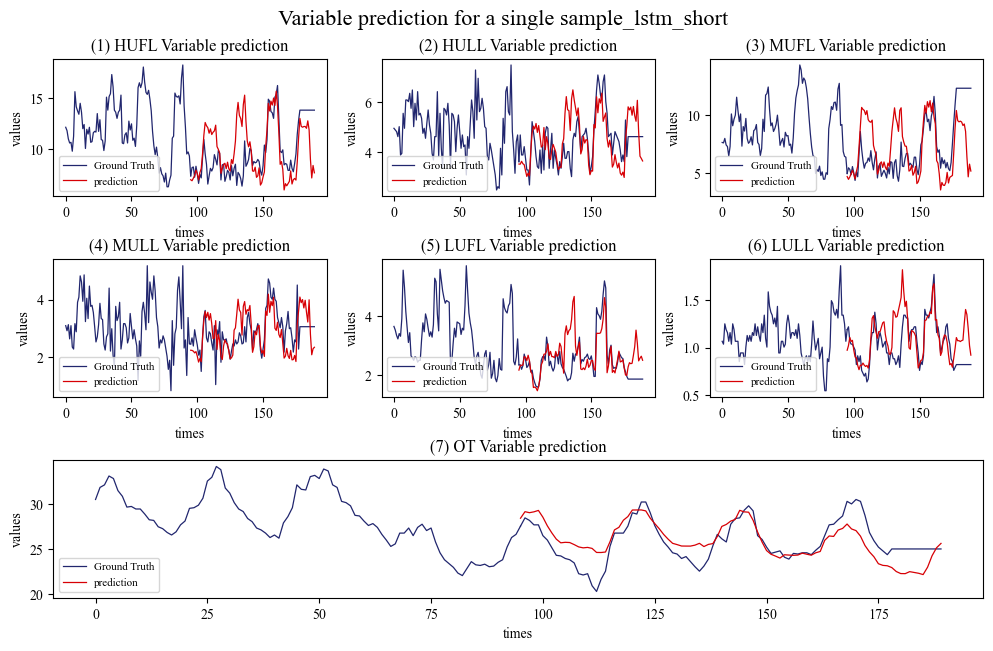

In [22]:
subplot_figure(model, dataset_test, scaler_model, device, 7,range_variable=[-2,-1],save_name='lstm_short')

# LSTM long

In [23]:
output_size = 336  # 预测维度
scaler_model = MinMaxScaler()
_, dataset_test, _ = data_process(root_path, input_size, output_size, timestep,scaler_model)
test_loader = DataLoader(dataset=dataset_test, batch_size=batch_size, shuffle=False)
model = torch.load('output/LSTM/lstm_long/LSTM_model_mse_long_final.pth')

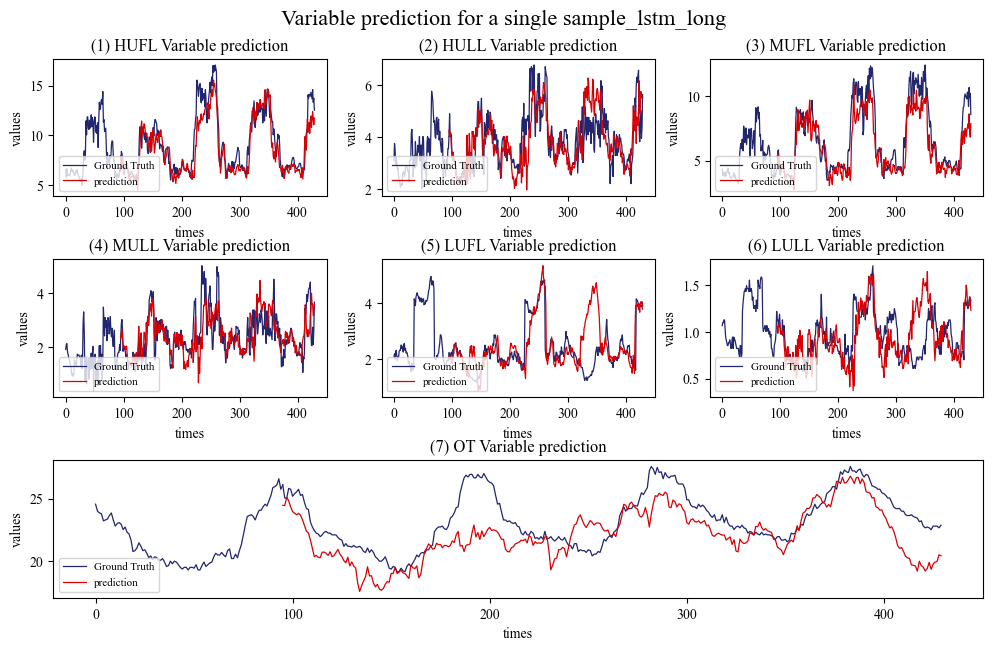

In [24]:
subplot_figure(model, dataset_test, scaler_model, device, 7,range_variable=[-2,-1],save_name='lstm_long')